In [1]:
## Necessary imports

import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"
os.environ["LD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import isothermal_transmission
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval, RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from petitRADTRANS.plotlib import plot_radtrans_opacities, plot_opacity_contributions
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.chemistry.utils import compute_mean_molar_masses
set_petitradtrans_plot_style()

Using pRT Plotting style!


In [2]:
## Loading the K2-18b data from the NASA Exoplanet Archive using the petitRADTRANS api
planet = Planet.get("K2-18 b")
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../petit"))

## Defining the retrieval config object
retrieval_config = RetrievalConfig(
    retrieval_name="K2-18b_isothermal_equilibrium",
    run_mode="retrieve",
    pressures=np.logspace(-6, 2, 120))

## First adding the NIRISS data in the 0.9 - 2.8 μm range
retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=isothermal_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

## Now the NIRSPEC data in the 2.8 μm range
retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=isothermal_transmission,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

## Adding physical properties of the system, not free parameters
retrieval_config.add_parameter('D_pl', False, value=planet.system_distance)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = planet.radius)
retrieval_config.add_parameter('mass', False, value = planet.mass)

## Temperature is added as free parameter
retrieval_config.add_parameter('temperature', True, transform_prior_cube_coordinate = lambda x : 800*x)
retrieval_config.add_parameter('log_Pcloud', True, transform_prior_cube_coordinate = lambda x: -6+7*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)
retrieval_config.add_parameter('C/O', True, transform_prior_cube_coordinate = lambda x: 0.2 + 1*x)
retrieval_config.add_parameter('Fe/H', True, transform_prior_cube_coordinate = lambda x: 0+3*x)

## Including continuum opacities
retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])

## Adding the line species. The abundance is the free parameter for each one
retrieval_config.set_line_species(['CH4', 'CO2', 'H2O', 'NH3'], eq=False, abund_lim = (-8.0,-0.1))

## Plotting parameters
retrieval_config.parameters['temperature'].plot_in_corner = True
retrieval_config.parameters['temperature'].corner_ranges = (0,1000)
retrieval_config.parameters['C/O'].plot_in_corner = False
retrieval_config.parameters['C/O'].corner_ranges = (0, 5)
retrieval_config.parameters['Fe/H'].plot_in_corner = False
retrieval_config.parameters['Fe/H'].corner_ranges = (0, 3)
for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)
retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

retrieval_config.plot_kwargs["nsample"] = 100
retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

## Addressing the outputs folder and creating the Retrieval object
output_directory = os.path.join(root_path, "outputs")
retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      evaluate_sample_spectra=False,
                      use_prt_plot_style=True)

## Then running the retrieval using 200 live points
retrieval.run(n_live_points=200,
              const_efficiency_mode=False,
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'H2O.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'NH3.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 L

In [3]:
## Getting samples
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths, best_fit_spectrum = retrieval.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=isothermal_transmission,
            )

Best fit likelihood = 28831.54
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_indu

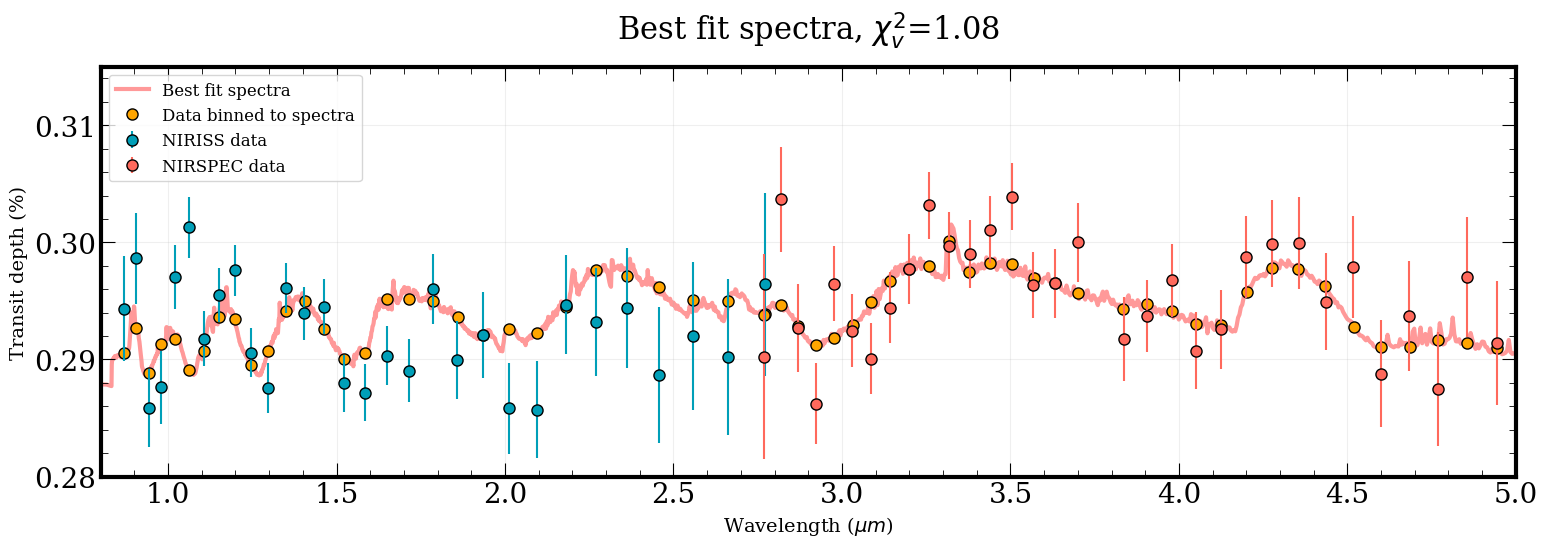

In [4]:
## Loading the low resolution spectra
niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")

## Binning the best fit model to spectra data
idx_niriss = []
idx_nirspec = []
for i in range(niriss["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-niriss["wl"][i])**2)
    idx_niriss.append(minIndex)
    
for j in range(nirspec["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-nirspec["wl"][j])**2)
    idx_nirspec.append(minIndex)

## Calculating the reduced chi squared
chi2 = retrieval.get_reduced_chi2_from_model(best_fit_wavelengths, best_fit_spectrum, subtract_n_parameters = True)

## Plot of the best-fit spectra
ax = plt.figure(figsize=(16,6)).gca()
ax.plot(best_fit_wavelengths, best_fit_spectrum*100, 
        color="red", alpha=0.4, linewidth=3, zorder=1, label="Best fit spectra")
ax.plot(best_fit_wavelengths[idx_niriss], best_fit_spectrum[idx_niriss]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2, label="Data binned to spectra")
ax.plot(best_fit_wavelengths[idx_nirspec], best_fit_spectrum[idx_nirspec]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2)
ax.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRISS data", zorder=3)
ax.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRSPEC data", zorder=3)
ax.set(xlim=(0.8, 5),
       xticks=np.arange(1, 5.5, 0.5), 
       ylim=(0.28, 0.315),
       yticks=[0.28, 0.29, 0.30, 0.31],
      )
ax.set_title(f'Best fit spectra, $\chi_v^2$={chi2:.2f}', pad = 20, fontsize=22)
ax.set_ylabel('Transit depth (%)', fontsize=14)
ax.set_xlabel(r'Wavelength (${\mu m}$)', fontsize=14)
ax.grid(alpha=0.2)
ax.legend(loc="upper left", fontsize=12)
plt.show()

In [5]:
## Calculating the forward best-fit model

parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'temperature': Parameter('temperature', False, value = retrieval.best_fit_parameters['temperature'].value),
    'C/O': Parameter('C/O', False, value = retrieval.best_fit_parameters['C/O'].value),
    'Fe/H': Parameter('Fe/H', False, value = retrieval.best_fit_parameters['Fe/H'].value),
    'CH4': Parameter('CH4', False, value= retrieval.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval.best_fit_parameters['CO2'].value),
    'H2O': Parameter('H2O', False, value= retrieval.best_fit_parameters['H2O'].value),
    'NH3': Parameter('NH3', False, value= retrieval.best_fit_parameters['NH3'].value),
}

line_species = [
    'CH4',
    'CO2',
    'H2O',
    'NH3'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,120)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = isothermal_transmission(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = isothermal_transmission(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N

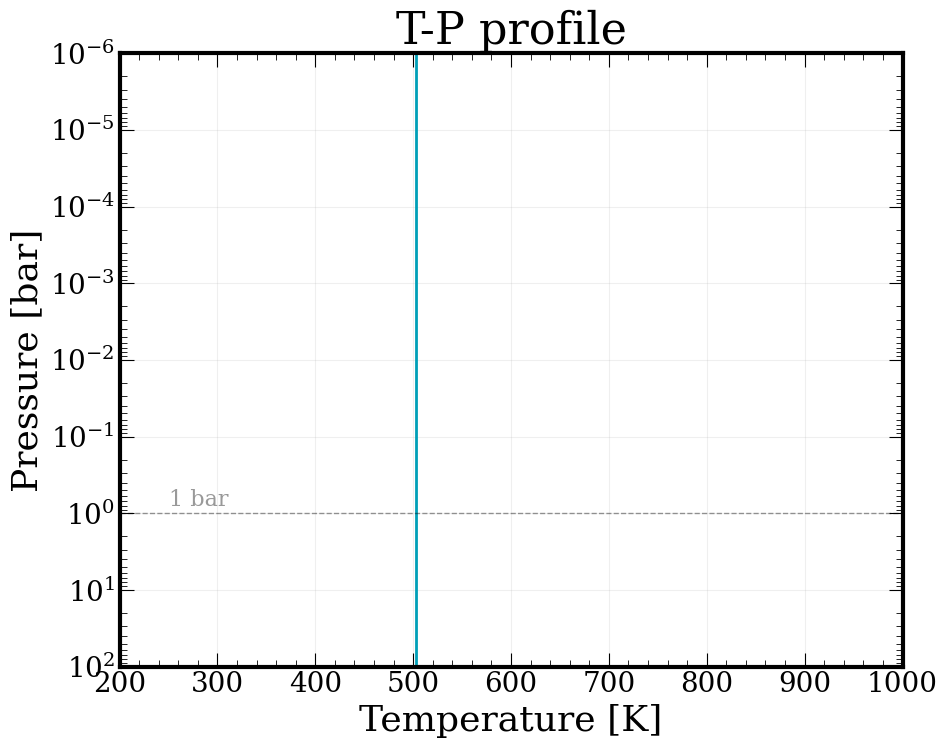

In [6]:
# fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)
# ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
# ax.text(200, 0.8, "1 bar", fontsize=16, alpha=0.4) 
# ax.invert_yaxis()
# plt.show()

## Temperature-pressure profile
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(temperature, pressure, linewidth = 2)
ax.set(xlabel="Temperature [K]",
       ylabel="Pressure [bar]",
       xlim=(200, 1000),
       ylim=(1e2,1e-6),
       yscale="log",
       title="T-P profile"
      )
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.text(250, 0.8, "1 bar", fontsize=16, alpha=0.4) 
ax.grid(alpha=0.2)
plt.show()

In [7]:
## Corner plot
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, plot_best_fit=True,title_kwargs= {"fontsize" : 10})
plt.show()

Not in evaluate mode. Changing run mode to evaluate.

Making corner plot


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9,) + inhomogeneous part.


Plotting Best-fit contribution function
Best fit likelihood = 28731.95
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/inpu

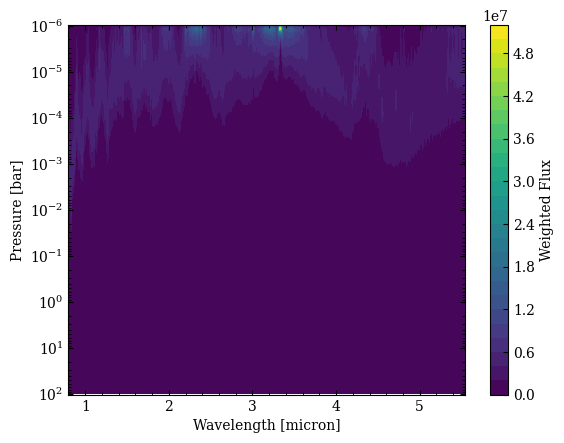

In [8]:
## Plotting the contribution function of each wavelength and each pressure
retrieval.plot_contribution(samples_use, parameters_read)
plt.show()

In [8]:
from petitRADTRANS.chemistry.pre_calculated_chemistry import PreCalculatedEquilibriumChemistryTable
chem = PreCalculatedEquilibriumChemistryTable()


co_ratios = retrieval.best_fit_parameters['C/O'].value * np.ones_like(pressures)
log10_metallicities = retrieval.best_fit_parameters['Fe/H'].value * np.ones_like(pressures)

mass_fractions, mean_molar_mass, nabla_ad = chem.interpolate_mass_fractions(
    co_ratios=co_ratios,
    log10_metallicities=log10_metallicities,
    temperatures=temperature,
    pressures=pressures,
    full=True
)

Loading chemical equilibrium chemistry table from file '/home/juan/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


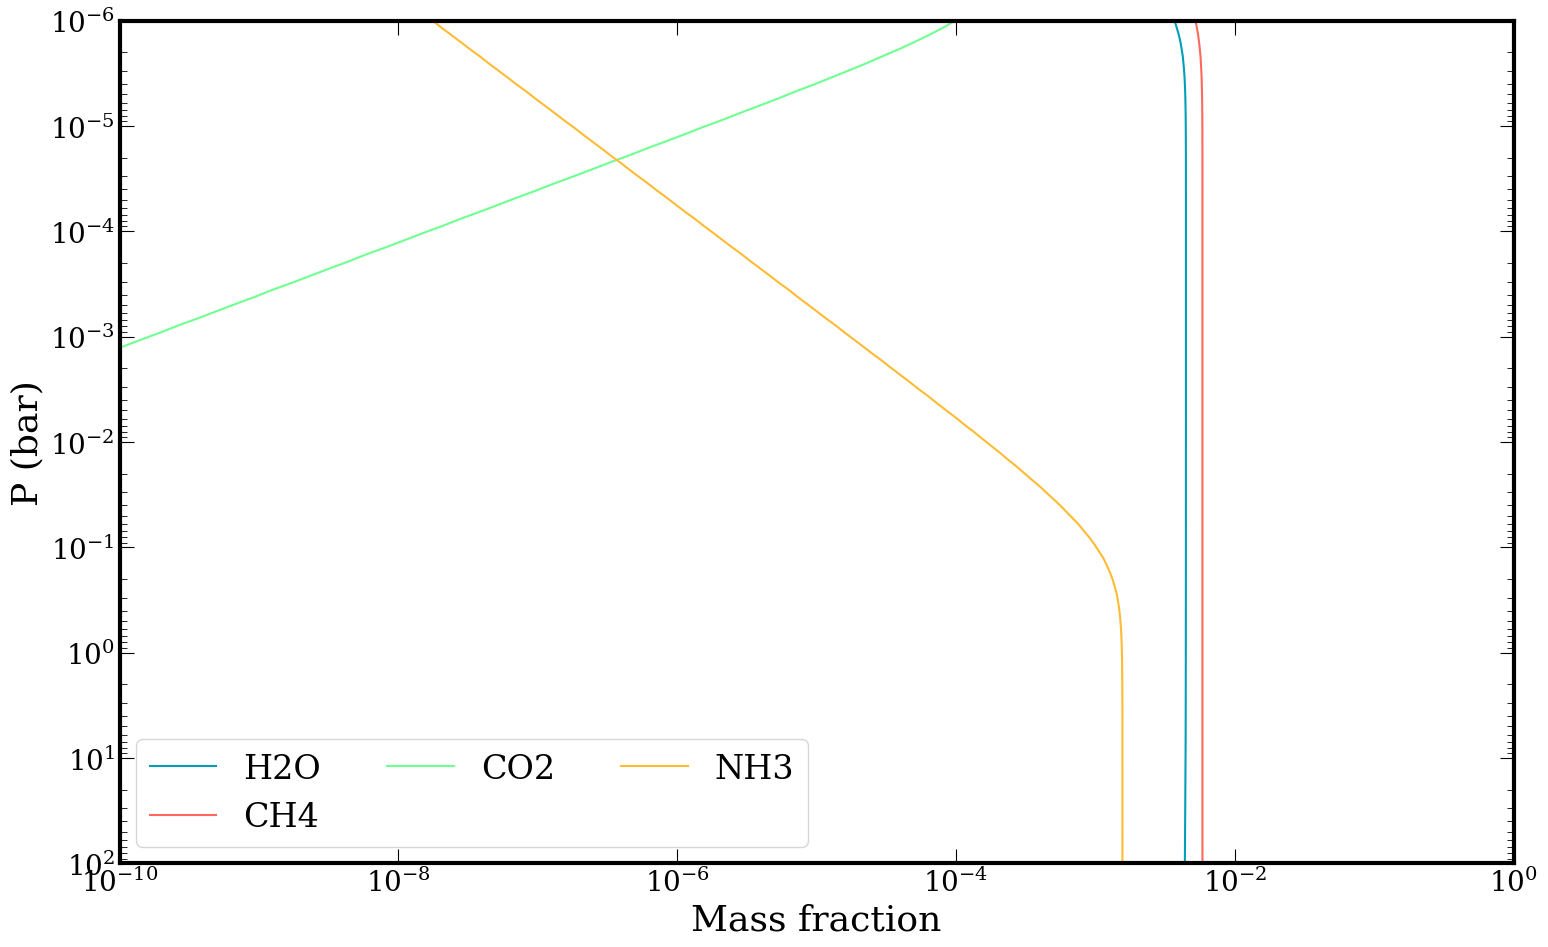

In [11]:
plt.yscale('log')
plt.xscale('log')
plt.ylim([100, 1e-6])
plt.xlim([1e-10, 1])

for species in mass_fractions.keys():
    if species in ['H2O', 'CH4', 'CO2', 'NH3']:
        plt.plot(mass_fractions[species], pressures, label=species)

plt.legend(loc='best', ncol=3)
plt.xlabel('Mass fraction')
plt.ylabel('P (bar)')
plt.show()

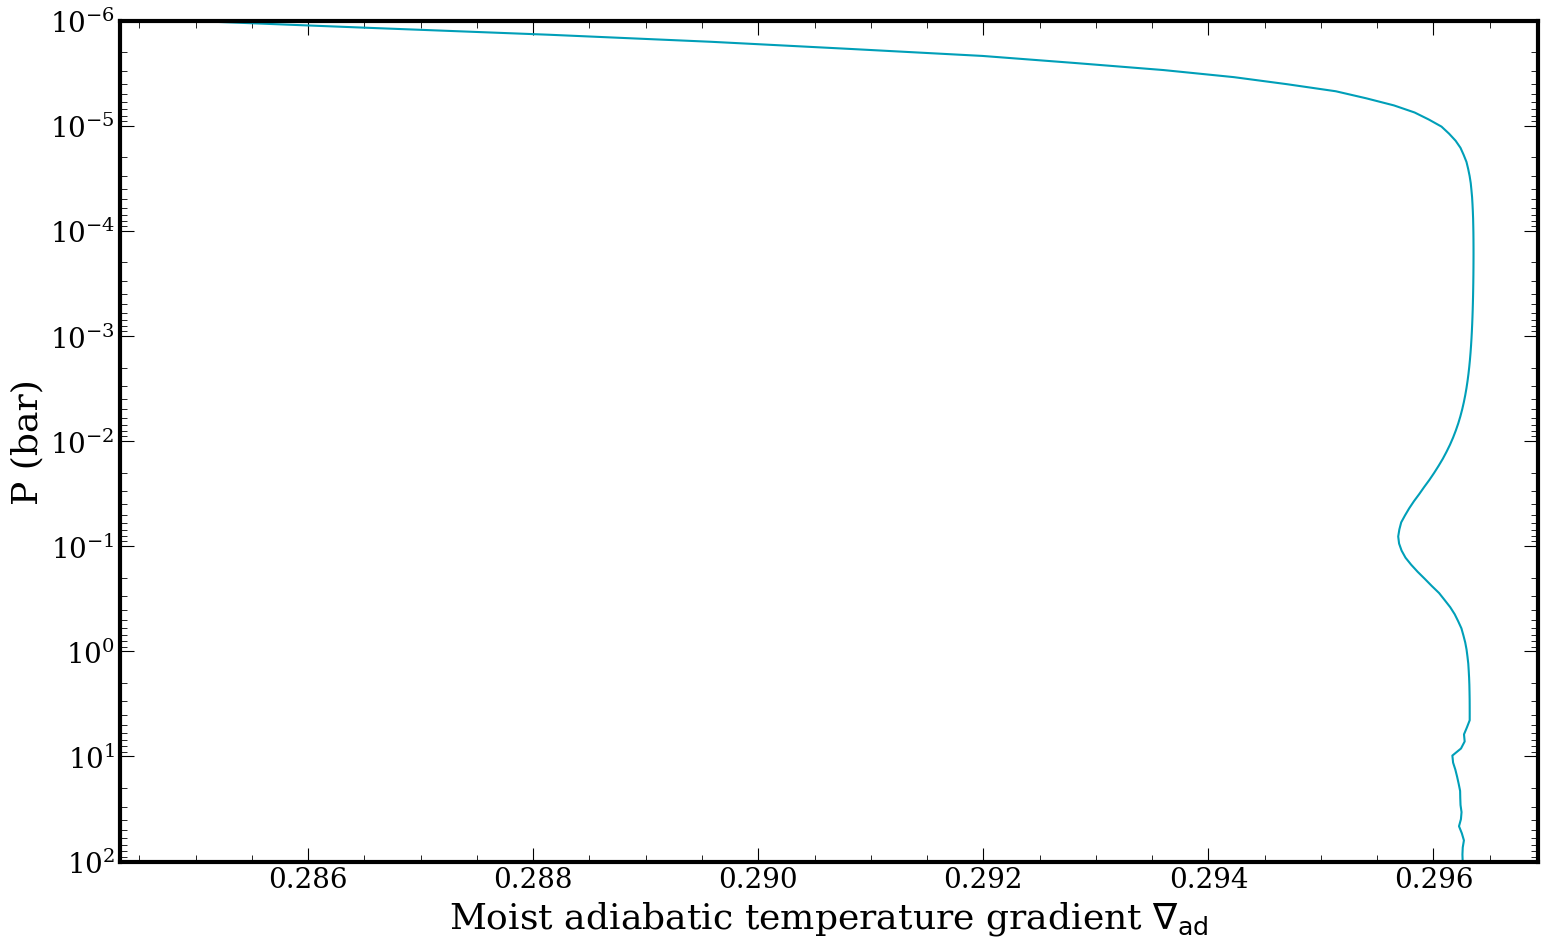

In [12]:
plt.yscale('log')
plt.ylim([100, 1e-6])

plt.plot(nabla_ad, pressures, label=species)

plt.xlabel(r'Moist adiabatic temperature gradient $\nabla_{\rm ad}$')
plt.ylabel('P (bar)')
plt.show()